# Recommendation System Project
##### [1. Word Cloud Generation with "지원동기"](#1.-Word-Cloud-Generation)
##### [2. Topic Modeling to extract values](#2.-Topic-Modeling)
##### [3. FFM Prediction](#3.-FFM)

## 1. Word Cloud Generation

page_1_to_10.csv's valid motivs: 75 out of 96
page_11_to_22.csv's valid motivs: 55 out of 111
page_23_to_100.csv's valid motivs: 647 out of 780
page_101_to_200.csv's valid motivs: 869 out of 1000
page_201_to_300.csv's valid motivs: 501 out of 1000
page_301_to_376.csv's valid motivs: 4 out of 755
total valid reasons: 2151


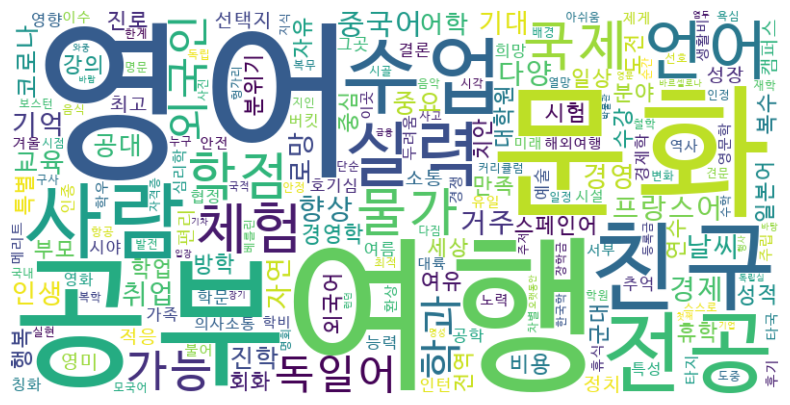

In [1]:
from extract_helper import *
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from konlpy.tag import Mecab
import os

path_to_files = "data_set"
files_to_process = ["page_1_to_10.csv", "page_11_to_22.csv", "page_23_to_100.csv", "page_101_to_200.csv", "page_201_to_300.csv", "page_301_to_376.csv"]

# 불용어 처리
stopwords = set()
with open("stopwords.txt", 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split()  # 기본적으로 공백을 기준으로 split
        stopwords.update(words)  # set에 words 추가 (중복 제거)

# 각 파일에서 '지원 동기'에 해당하는 부분 parse
mecab = Mecab()  # mecab 형태소 분석기 생성
cleaned_text = ""
total_motivs = pd.Series(dtype=str)
for file_name in files_to_process:
    file_path = os.path.join(path_to_files, file_name)
    df = pd.read_csv(file_path)
    
    # csv 파일 내용 parse
    df['Selected Content'] = df.apply(select_content, axis=1)
    df['Processed Content'] = df.apply(process_content, axis=1)
    tot_len = len(df['Processed Content'])
    motivs = df['Processed Content'].dropna() # NAN 제거
    motivs = motivs[motivs.str.strip() != ""]  # 빈 문자열 제거
    
    print(f"{file_name}'s valid motivs: {len(motivs)} out of {tot_len}")
    total_motivs = pd.concat([total_motivs, motivs])

    # 텍스트 전처리
    text = ' '.join(motivs)  # 모든 텍스트를 결합
    nouns = mecab.nouns(text)  # 명사만 추출
    nouns = [word for word in nouns if len(word) > 1] # 한글자 삭제

    # 명사 리스트를 하나의 문자열로 변환
    cleaned_text += ' '.join(nouns)

print(f"total valid reasons: {len(total_motivs)}")

# WordCloud 객체 생성
cleaned_text = cleaned_text.split()
cleaned_text_cnt = Counter(cleaned_text)
min_freq = 10
cleaned_text_flt = {word: count for word, count in cleaned_text_cnt.items() if count >= min_freq and word not in stopwords}

font_path = "/Users/gayeonlee/Library/Fonts/D2Coding-Ver1.3.2-20180524.ttc"
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, stopwords=stopwords).generate_from_frequencies(cleaned_text_flt)

# 워드 클라우드 표시
plt.figure(figsize=(10, 5))
plt.rc('font', family='NanumGothicOTF')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 제거
plt.show()



## 2. Topic Modeling

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# total_motivs 인덱스 재설정
total_motivs = total_motivs.reset_index(drop=True)

# 불용어 처리 및 전처리
total_motivs_filtered = total_motivs.apply(lambda x: preprocess_text(x, stopwords, mecab))

# 문서-단어 행렬 생성
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(total_motivs_filtered)

# LDA 모델 학습
num_topics = 3  # 주제 수
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# 주제별 상위 단어 출력
terms = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    print(f"\n주제 {idx + 1}:")
    print([terms[i] for i in topic.argsort()[:-11:-1]])

# 문서별 주제 분포 출력
doc_topics = lda.transform(X)
doc_topic_df = pd.DataFrame(doc_topics, columns=[f"주제 {i + 1}" for i in range(num_topics)])

# total_motivs와 병합
if len(doc_topic_df) == len(total_motivs):
    doc_topic_df['Processed Content'] = total_motivs.values
else:
    raise ValueError("Mismatch in lengths of doc_topic_df and total_motivs")

print("\n문서별 주제 분포:")
print(doc_topic_df)

# 문서별 주요 주제 확인
doc_topic_df['Value'] = doc_topic_df.iloc[:, :-1].idxmax(axis=1)
print("\n문서별 주요 주제:")
print(doc_topic_df[['Processed Content', 'Value']])


# 문서-단어 행렬과 LDA 모델 결과를 시각화에 맞게 변환
lda_vis_data = pyLDAvis.prepare(
    topic_term_dists=lda.components_,          # LDA 주제-단어 분포
    doc_topic_dists=lda.transform(X),         # 문서-주제 분포
    doc_lengths=X.sum(axis=1).A1,             # 각 문서의 단어 수
    vocab=vectorizer.get_feature_names_out(), # 단어 목록
    term_frequency=X.sum(axis=0).A1          # 전체 단어 빈도
)

# Step 4: 시각화 출력
pyLDAvis.display(lda_vis_data)
pyLDAvis.save_html(lda_vis_data, 'lda_visualization_3.html')

# # 전처리된 텍스트를 토큰화된 리스트로 변환
# tokenized_texts = total_motivs_filtered.apply(lambda x: x.split()).tolist()

# # Step 2: Create a Gensim Dictionary and Corpus
# dictionary = corpora.Dictionary(tokenized_texts)
# corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# # Step 3: Train the LDA model using Gensim
# num_topics = 3  # 주제 수
# lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# # Step 4: Visualize using pyLDAvis
# lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

# # Display the visualization
# pyLDAvis.enable_notebook() 
# pyLDAvis.display(lda_vis)


주제 1:
['여행', '친구', '영어', '공부', '물가', '사람', '외국인', '로망', '학점', '행복']

주제 2:
['영어', '전공', '수업', '공부', '문화', '실력', '중국어', '프랑스어', '경영', '학과']

주제 3:
['문화', '영어', '여행', '공부', '사람', '언어', '독일어', '수업', '체험', '실력']

문서별 주제 분포:
          주제 1      주제 2      주제 3  \
0     0.814209  0.096339  0.089452   
1     0.923830  0.035854  0.040315   
2     0.055231  0.499033  0.445736   
3     0.970875  0.004051  0.025073   
4     0.944558  0.028148  0.027294   
...        ...       ...       ...   
2146  0.251156  0.021433  0.727410   
2147  0.030797  0.029069  0.940134   
2148  0.031030  0.235878  0.733091   
2149  0.615116  0.024022  0.360862   
2150  0.944256  0.025307  0.030437   

                                      Processed Content  
0     군대에서 동기가 교환학생을 간다는 소식을 듣고, 흥미를 보이던 와중 군 선임들 및 ...  
1     교환학생을 가기 전에는 설레임으로 가득차고, 해외살이에 대한 환상이 가득한 상태였지...  
2     저는 졸업 전에 교환만큼은 꼭 가고 싶었습니다. 취업을 하면 이런 기회는 오지 않기...  
3     저는 교환도시와 교환교를 결정할 때 정말 많은 시간을 들였습니다. 위치, 날씨, 학...  
4     교환 학생은 중고등학교 시절부터 대학생이 된다면